In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import seaborn as sns

from cert_collective.cert_collective import collective_certificate_grid
from cert_collective.utils import gcn_receptive_field_mask

In [2]:
plt.rcParams['figure.figsize'] = [8,5]

## Load graph and base certificate

In [3]:
graph = np.load('data/graphs/cora_ml.npz', allow_pickle=True)

# Pair of binary scipy sparse matrices
attr = graph['attr'][()] 
adj = graph['adj'][()]
n_nodes = attr.shape[0]

base_cert_grid = np.load('data/base_certs/cora_ml/attr_grid.npy')

Text(0.5, 1.0, 'Base certificate')

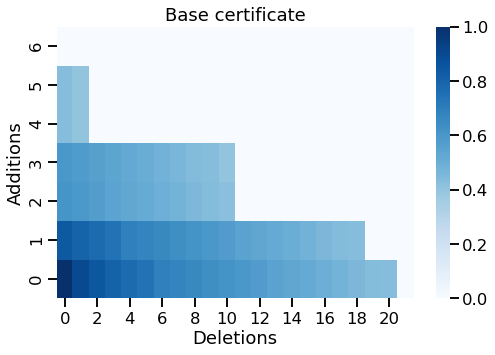

In [4]:
heatmap = base_cert_grid.mean(0)
sns.set_context('talk')
sns.heatmap(heatmap, 
            cmap='Blues',
            vmin=0, vmax=1)

plt.xlim(0, heatmap.shape[1])
plt.ylim(0, heatmap.shape[0])
plt.xlabel('Deletions')
plt.ylabel('Additions')
plt.title('Base certificate')

## Specify base cert dimensions and receptive fields

In [5]:
print(base_cert_grid.shape)

dim_labels = ['attr_add', 'attr_del']

n_layers = 2
# List of binary sparse matrices
receptive_field_masks = [gcn_receptive_field_mask(adj, dim_label, n_layers, n_nodes)
                         for dim_label in dim_labels]

(2810, 7, 22)


## Attribute additions

In [6]:
print(f'Istalled solvers: {cp.installed_solvers()}')

solver = 'MOSEK'

Istalled solvers: ['CVXOPT', 'ECOS', 'GLPK', 'GLPK_MI', 'GUROBI', 'MOSEK', 'OSQP', 'SCS']


In [7]:
collective_grid_add = collective_certificate_grid(
    base_cert_grid, dim_labels, receptive_field_masks, attr, adj, max_rad=[0, 9, 0],
    solver=solver
)[0, :, 0]

(0.0, 1.0)

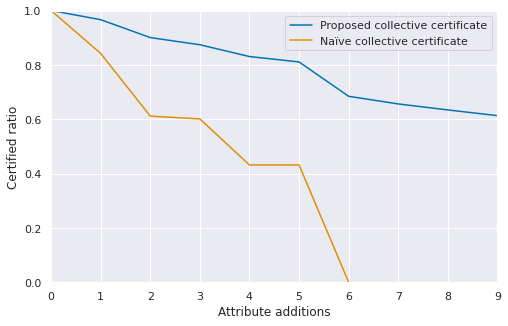

In [8]:
sns.set()
pal = sns.color_palette('colorblind', 2)

plt.plot(collective_grid_add / n_nodes, color=pal[0], label='Proposed collective certificate')
plt.plot(base_cert_grid.mean(axis=0)[:, 0], color=pal[1], label='Naïve collective certificate')

plt.legend()
plt.xlabel('Attribute additions')
plt.ylabel('Certified ratio')
plt.xlim(0, 9)
plt.ylim(0, 1)

## Attribute deletions

In [9]:
collective_grid_del = collective_certificate_grid(
    base_cert_grid, dim_labels, receptive_field_masks, attr, adj, max_rad=[0, 0, 32],
    solver=solver
)[0, 0, :]

(0.0, 1.0)

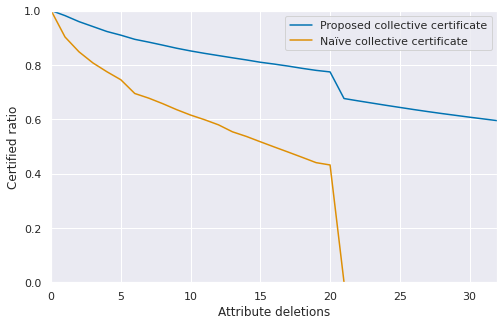

In [10]:
sns.set()
pal = sns.color_palette('colorblind', 2)

plt.plot(collective_grid_del / n_nodes, color=pal[0], label='Proposed collective certificate')
plt.plot(base_cert_grid.mean(axis=0)[0, :], color=pal[1], label='Naïve collective certificate')

plt.legend()
plt.xlabel('Attribute deletions')
plt.ylabel('Certified ratio')
plt.xlim(0, 32)
plt.ylim(0, 1)

## Local constraints and limited attacker-controlled nodes

In [11]:
collective_grid_del_local = collective_certificate_grid(
    base_cert_grid, dim_labels, receptive_field_masks, attr, adj, max_rad=[0, 0, 32],
    local_budget_descriptor=np.array([0, 0, 4]), local_budget_mode='absolute', num_attackers=6,
    solver=solver
)[0, 0, :]

(0.0, 1.0)

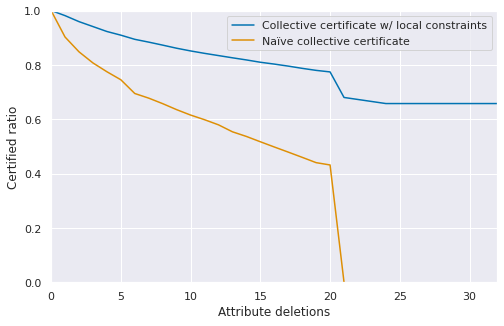

In [12]:
sns.set()
pal = sns.color_palette('colorblind', 2)
plt.plot(collective_grid_del_local / n_nodes, color=pal[0], label='Collective certificate w/ local constraints')
plt.plot(base_cert_grid.mean(axis=0)[0, :], color=pal[1], label='Naïve collective certificate')
plt.legend()
plt.xlabel('Attribute deletions')
plt.ylabel('Certified ratio')
plt.xlim(0, 32)
plt.ylim(0, 1)